<a href="https://colab.research.google.com/github/MelikbekyanAshot/Data-Science/blob/main/JourneyToSpringfield.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт библиотек

In [75]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

import numpy as np
import pandas as pd

from sklearn.metrics import f1_score

from torchsummary import summary

from sklearn.preprocessing import LabelEncoder
from PIL import Image

import pickle

import matplotlib.pyplot as plt

from tqdm import tqdm, tqdm_notebook

import PIL

import re

from collections import OrderedDict

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
!unzip -q /content/gdrive/My\ Drive/journey-springfield.zip

In [4]:
from skimage import io

from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder

In [28]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ResNet

In [6]:
class Block(nn.Module):
  def __init__(self, num_layers, in_channels, out_channels, identity_downsample=None, stride=1):
    super(Block, self).__init__()
    self.num_layers = num_layers
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.conv3 = nn.Conv2d(out_channels, out_channels * 4, kernel_size=1, stride=1, padding=0)
    self.bn3 = nn.BatchNorm2d(out_channels * 4)
    self.relu = nn.ReLU()
    self.identity_downsample = identity_downsample

  def forward(self, x):
    identity = x
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)
    x = self.conv3(x)
    x = self.bn3(x)

    if self.identity_downsample is not None:
      identity = self.identity_downsample(identity)

    x += identity
    x = self.relu(x)
    return x


class ResNet34(nn.Module):
  def __init__(self):
    super(ResNet34, self).__init__()
    self.in_channels = 64
    self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
    self.bn1 = nn.BatchNorm2d(64)
    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    # ResNetLayers
    self.layer1 = self.__make_layers(num_residual_blocks=3, intermediate_channels=64, stride=1)
    self.layer2 = self.__make_layers(num_residual_blocks=4, intermediate_channels=128, stride=2)
    self.layer3 = self.__make_layers(num_residual_blocks=6, intermediate_channels=256, stride=2)
    self.layer4 = self.__make_layers(num_residual_blocks=3, intermediate_channels=512, stride=2)

    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Linear(512 * 4, 42)

  def __make_layers(self, num_residual_blocks, intermediate_channels, stride):
    layers = []

    identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, intermediate_channels*4, kernel_size=1, stride=stride),
                                        nn.BatchNorm2d(intermediate_channels*4))
    layers.append(Block(34, self.in_channels, intermediate_channels, identity_downsample, stride))
    self.in_channels = intermediate_channels * 4 
    for i in range(num_residual_blocks - 1):
      layers.append(Block(34, self.in_channels, intermediate_channels)) 
    return nn.Sequential(*layers)

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    x = self.avgpool(x)
    x = x.reshape(x.shape[0], -1)
    x = self.fc(x)
    return x


# DataLoader

In [7]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

# Подготовка данных

Ссылка на данные: https://www.kaggle.com/competitions/journey-springfield/data

In [15]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = (list(TRAIN_DIR.rglob('*.jpg')))
test_files = (list(TEST_DIR.rglob('*.jpg')))
# test_dict = {int(re.sub('\D', '', str(file))): file for file in (list(TEST_DIR.rglob('*.jpg')))}
# test_files = [value for _, value in sorted(test_dict.items())]

In [31]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [17]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [32]:
train_dataset = SimpsonsDataset(train_files, mode='train')
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [51]:
val_dataset = SimpsonsDataset(val_files, mode='val')
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

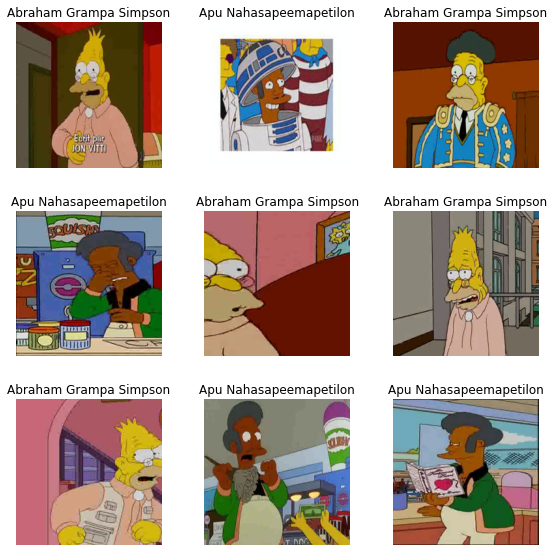

In [28]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
  fig_x.axis('off')
  random_characters = int(np.random.uniform(0,1000))
  im_val, label = train_loader.dataset[random_characters]
  img_label = " ".join(map(lambda x: x.capitalize(),\
              train_loader.dataset.label_encoder.inverse_transform([label])[0].split('_')))
  imshow(im_val.data.cpu(), \
        title=img_label,plt_ax=fig_x)
fig.tight_layout()

# Обучение

In [52]:
model = ResNet34().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
loss_function = nn.CrossEntropyLoss()  
EPOCHS = 3

f1_score_train = []
f1_score_val = []

for epoch in range(EPOCHS):
  model.train()
  current_train_score = []
  for batch, labels in tqdm(train_loader):
    batch, labels = batch.to(DEVICE), labels.to(DEVICE)
    optimizer.zero_grad()
    prediction = model(batch)
    loss = loss_function(prediction, labels)
    loss.backward()
    optimizer.step()
    current_train_score.append(f1_score(labels.cpu(), 
                                     prediction.cpu().argmax(-1),
                                     average='micro'))
  f1_score_train.append(np.mean(current_train_score))

  model.eval()
  current_val_score = []
  with torch.no_grad():
    for batch, labels in val_loader:
      batch, labels = batch.to(DEVICE), labels.to(DEVICE)
      prediction = model(batch).argmax(-1)
      current_val_score.append(f1_score(labels.cpu(), 
                                      prediction.cpu(),
                                      average='micro'))
    f1_score_val.append(np.mean(current_val_score))

  print(f'Эпоха {epoch + 1}: f1 score train = {f1_score_train[-1]}, f1 socre val = {f1_score_val[-1]}')

100%|██████████| 246/246 [09:07<00:00,  2.22s/it]


Эпоха 1: f1 score train = 0.43992364676936246, f1 socre val = 0.37614329268292684


100%|██████████| 246/246 [09:05<00:00,  2.22s/it]


Эпоха 2: f1 score train = 0.7309250641848525, f1 socre val = 0.7272789634146342


100%|██████████| 246/246 [09:05<00:00,  2.22s/it]


Эпоха 3: f1 score train = 0.8158997913992297, f1 socre val = 0.8122179878048781


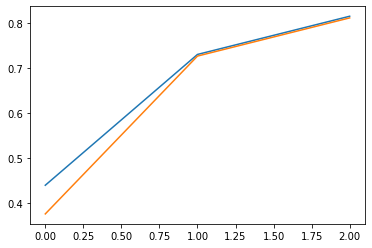

In [53]:
plt.plot(f1_score_train)
plt.plot(f1_score_val)

In [120]:
torch.save(model.state_dict() , '/content/gdrive/MyDrive/DataScience/МФТИ/JourneyToSpringfield /resnet_v1.1.pt')

# Тестирование

In [19]:
model = ResNet34()
model.load_state_dict(torch.load('/content/gdrive/MyDrive/DataScience/МФТИ/JourneyToSpringfield /resnet_v1.1.pt', 
                                 map_location=torch.device('cpu')))

<All keys matched successfully>

In [47]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)

In [ ]:
test_loader.dataset.files

In [33]:
labels = train_dataset.label_encoder.classes_

In [59]:
prediction = []
model.eval()
with torch.no_grad():
  for batch in tqdm(test_loader):
    batch = batch.to(DEVICE)
    output = model(batch).argmax(-1).cpu().numpy()
    prediction.extend(labels[output])

100%|██████████| 16/16 [03:57<00:00, 14.83s/it]


In [ ]:
submission = {}
for file, pred in zip(test_loader.dataset.files, prediction):
  file_number = int(re.sub('\D', '', str(file)))
  submission[file_number] = pred 
submission 

In [83]:
ordered_submission = OrderedDict()
for key, value in sorted(submission.items()):
  ordered_submission[f'img{key}.jpg'] = value

In [84]:
kaggle_submission = pd.DataFrame({'id': ordered_submission.keys(), 'Expected': ordered_submission.values()}, )
kaggle_submission.to_csv('submission2.csv', index=False)

In [85]:
kaggle_submission

,id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img2.jpg,mayor_quimby
3,img3.jpg,comic_book_guy
4,img4.jpg,lisa_simpson
...,...,...
986,img986.jpg,sideshow_bob
987,img987.jpg,nelson_muntz
988,img988.jpg,marge_simpson
989,img989.jpg,charles_montgomery_burns
